In [1]:
import pandas as pd
import numpy as np
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

import warnings
warnings.filterwarnings('ignore')

In [2]:
DATA_DIR = '../data'
MODEL_DIR = '../models'
SEED = 42 # used to fix random_state

In [3]:
full_train_df = pd.read_csv(DATA_DIR + '/processed/full_train.csv', index_col=0)

In [4]:
print(full_train_df.shape)
full_train_df.head(5)

(40000, 2)


,review,sentiment
0,thats kept asking many fight screaming match s...,0
1,watch entire movie could watch entire movie st...,0
2,touching love story reminiscent mood love draw...,1
3,latterday fulci schlocker totally abysmal conc...,0
4,first firmly believe norwegian movie continual...,0


## 1. Model training and selection

Let's split full training dataset into training and validation parts at first.

In [5]:
train_df, val_df = train_test_split(full_train_df, test_size=0.25, shuffle=True, random_state=SEED)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

As mentioned in [01-tk-data-preprocessing-and-EDA.ipynb](01-tk-data-preprocessing-and-EDA.ipynb), we need to remove data duplicates from our training dataset. It's time to do it.

In [6]:
train_df = train_df.drop_duplicates()

In [7]:
train_df

,review,sentiment
0,one game love bit hate shred even hardcore mar...,1
1,film noire set piece suffers murky sound least...,1
2,sat turkey seen premise sounded like potential...,0
3,excellent film depicting cross current life mu...,1
4,cast actor actress columbo episode beside pete...,1
...,...,...
29995,one creepy underrated gem chilling performance...,1
29996,final chapter hanzo razor trilogy provides fit...,1
29997,saw movie say drive in day seems like would gr...,0
29998,cameron diaz woman married judge played harvey...,0


In [8]:
X_train, y_train = train_df['review'], train_df['sentiment']
X_val, y_val = val_df['review'], val_df['sentiment']

In [9]:
print(f'Training dataset shape is {X_train.shape}, validation part shape is {X_val.shape}.')

Training dataset shape is (29849,), validation part shape is (10000,).


Before training different models, we need to transform our text collections into a matrix of tokens. For such purposes we are going to use two types of transformations on data: `CountVectorizer` and `TfidfVectorizer`. It's the most popular feature extraction techniques for text data. After that we will train models on each and choose the best one.
* [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) converts a collection of text documents to a matrix of token counts: the occurrences of tokens in each document or bag of words.
* [TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) converts a collection of raw documents to a matrix of [TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) features: it computes the word counts, IDF values, and TF-IDF scores all using the same data set.

Both are the most popular feature extraction techniques for text data.

So, let's create both transformations and apply them to our training dataset.

In [10]:
cv = CountVectorizer()
X_train_cv = cv.fit_transform(X_train)
X_val_cv = cv.transform(X_val)

In [11]:
tv = TfidfVectorizer()
X_train_tfidf = tv.fit_transform(X_train)
X_val_tfidf = tv.transform(X_val)

In [12]:
def calc_metrics(y_true: pd.Series, y_pred: np.array, predict_proba: np.array) -> dict:
    """ Calculates and prints basic metrics """
    accuracy = round(accuracy_score(y_true, y_pred), 3)
    precision = round(precision_score(y_true, y_pred, average='binary'), 3)
    recall = round(recall_score(y_true, y_pred, average='binary'), 3)
    f1 = round(f1_score(y_true, y_pred, average='binary'), 3)
    if predict_proba.size:
        roc_auc = round(roc_auc_score(y_true, predict_proba[:, 1]), 3)
    else:
        roc_auc = None

    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1-score: {f1}')
    print(f'ROC-AUC: {roc_auc}')
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'ROC_AUC': roc_auc
    }

In [13]:
score = dict()
scores_df = pd.DataFrame()

It's time to try different models for training. We start from linear models. With Logistic Regression, to be exact.

### 1.1. Logistic Regression

For a start, we will take dataset transformed by CountVectorizer.

In [14]:
%%time
model_lr = LogisticRegression(random_state=SEED)
model_lr.fit(X_train_cv, y_train)

Wall time: 7.93 s


LogisticRegression(random_state=42)

In [15]:
y_pred_train = model_lr.predict(X_train_cv)
proba_train = model_lr.predict_proba(X_train_cv)

Next we calculate some metrics on training dataset and then on validation part.

In [16]:
print(f'Logistic Regression metrics on training data:')
score['model'] = 'CountVect_LogisticRegression_train'
score.update(calc_metrics(y_train, y_pred_train, proba_train))
scores_df = scores_df.append(score, ignore_index=True)

Logistic Regression metrics on training data:
Accuracy: 0.997
Precision: 0.997
Recall: 0.997
F1-score: 0.997
ROC-AUC: 1.0


In [17]:
y_pred_val = model_lr.predict(X_val_cv)
proba_val = model_lr.predict_proba(X_val_cv)

In [18]:
print(f'Logistic Regression metrics on validation data:')
score['model'] = 'CountVect_LogisticRegression_val'
score.update(calc_metrics(y_val, y_pred_val, proba_val))
scores_df = scores_df.append(score, ignore_index=True)

Logistic Regression metrics on validation data:
Accuracy: 0.877
Precision: 0.881
Recall: 0.876
F1-score: 0.879
ROC-AUC: 0.945


Then we plot the classification report ...

In [19]:
report_lr_cv = classification_report(y_val, y_pred_val, target_names=['negative', 'positive'])
print(report_lr_cv)

              precision    recall  f1-score   support

    negative       0.87      0.88      0.88      4937
    positive       0.88      0.88      0.88      5063

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



... and confusion matrix.

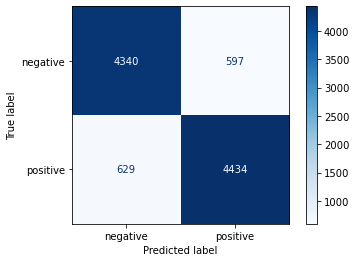

In [20]:
plot_confusion_matrix(model_lr, X_val_cv, y_val, cmap = 'Blues', display_labels=['negative', 'positive'])
plt.grid(False)

The results are quite good enough. Let's try to train Logistic Regression on a data transformed by TfidfVectorizer. We will repeat all the above steps.

In [21]:
%%time
model_lr.fit(X_train_tfidf, y_train)

Wall time: 2.24 s


LogisticRegression(random_state=42)

In [22]:
y_pred_train = model_lr.predict(X_train_tfidf)
proba_train = model_lr.predict_proba(X_train_tfidf)

In [23]:
print(f'Logistic Regression metrics on training data:')
score['model'] = 'TfidfVect_LogisticRegression_train'
score.update(calc_metrics(y_train, y_pred_train, proba_train))
scores_df = scores_df.append(score, ignore_index=True)

Logistic Regression metrics on training data:
Accuracy: 0.934
Precision: 0.926
Recall: 0.943
F1-score: 0.934
ROC-AUC: 0.982


In [24]:
y_pred_val = model_lr.predict(X_val_tfidf)
proba_val = model_lr.predict_proba(X_val_tfidf)

In [25]:
print(f'Logistic Regression metrics on validation data:')
score['model'] = 'TfidfVect_LogisticRegression_val'
score.update(calc_metrics(y_val, y_pred_val, proba_val))
scores_df = scores_df.append(score, ignore_index=True)

Logistic Regression metrics on validation data:
Accuracy: 0.89
Precision: 0.89
Recall: 0.894
F1-score: 0.892
ROC-AUC: 0.958


In [26]:
report_lr_tfidf = classification_report(y_val, y_pred_val, target_names=['negative', 'positive'])
print(report_lr_tfidf)

              precision    recall  f1-score   support

    negative       0.89      0.89      0.89      4937
    positive       0.89      0.89      0.89      5063

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



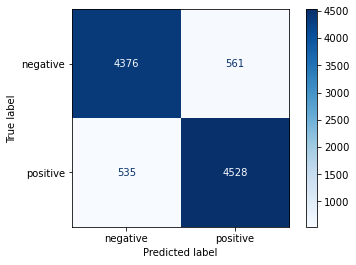

In [27]:
plot_confusion_matrix(model_lr, X_val_tfidf, y_val, cmap = 'Blues', display_labels=['negative', 'positive'])
plt.grid(False)

In [28]:
scores_df.set_index('model')

,accuracy,precision,recall,f1_score,ROC_AUC
model,,,,,
CountVect_LogisticRegression_train,0.997,0.997,0.997,0.997,1.000
CountVect_LogisticRegression_val,0.877,0.881,0.876,0.879,0.945
TfidfVect_LogisticRegression_train,0.934,0.926,0.943,0.934,0.982
TfidfVect_LogisticRegression_val,0.890,0.890,0.894,0.892,0.958


As you can see from this table, we got a slightly better results for the data after CountVectorizer transformation over the training part (`ROC_AUC = 1.0`). But at the same time, all metrics on the validation dataset are more preferable for the data after TfidfVectorizer convertion.

What we do next is hyperparameters tuning. First we will do it manually by searching each parameter step by step and dropping out the worst one. Then we are going to take a special function that is usually used for such kind of purpose.

The transformers like CountVectorizer or TfidfVectorizer have the following parameters to tune:
* `ngram_range` - the lower and upper boundary of the range of n-values for different word n-grams to be extracted;
* `max_df` - when building the vocabulary ignore terms that have a document frequency strictly higher than the given threshold (corpus-specific stop words).
* `max_features` - build a vocabulary that only consider the top max_features ordered by term frequency across the corpus.

**Note: All the next steps related to parameters tuning can take a significant amount of your time (from 10 to 60 minutes for each notebook cell). So please be careful!**

We start with CountVectorizer as a transformer, and our first parameter for turning will be `ngram_range`.

In [29]:
scores = []
ngram_range = [(1, 1), (1, 2), (1, 3)]
for ngram in ngram_range:
    pipeline = Pipeline([
        ('transformer', CountVectorizer(ngram_range=ngram)),
        ('model', LogisticRegression(random_state=SEED)),
    ])
    pipeline.fit(X_train, y_train)

    y_pred = pipeline.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    
    scores.append((ngram, accuracy))

In [30]:
scores

[((1, 1), 0.8774), ((1, 2), 0.8924), ((1, 3), 0.8918)]

Using only unigrams give us a worse result. Therefore, we continue with `ngram_range=[(1, 2), (1, 3)]`. Next, we will tune `max_df` parameter.

In [31]:
scores = []
ngram_range = [(1, 2), (1, 3)]
max_df_range = [0.5, 0.75, 1]
for max_df in max_df_range:
    for ngram in ngram_range:
        pipeline = Pipeline([
            ('transformer', CountVectorizer(ngram_range=ngram, max_df=max_df)),
            ('model', LogisticRegression(random_state=SEED)),
        ])
        pipeline.fit(X_train, y_train)

        y_pred = pipeline.predict(X_val)
        accuracy = accuracy_score(y_val, y_pred)

        scores.append((max_df, ngram, accuracy))

In [32]:
scores

[(0.5, (1, 2), 0.8924),
 (0.5, (1, 3), 0.8913),
 (0.75, (1, 2), 0.8924),
 (0.75, (1, 3), 0.8918),
 (1, (1, 2), 0.6889),
 (1, (1, 3), 0.7223)]

Here we got the best results with `ngram_range=[(1, 2), (1, 3)]` and `max_df=[0.5, 0.75]`. Let's move on to the next parameter - `max_features`.

In [33]:
scores = []
ngram_range = [(1, 2), (1, 3)]
max_df_range = [0.5, 0.75]
max_features_range = [None, 10000, 50000]
for max_ft in max_features_range:
    for max_df in max_df_range:
        for ngram in ngram_range:
            pipeline = Pipeline([
                ('transformer', 
                     CountVectorizer(
                         ngram_range=ngram, 
                         max_df=max_df, 
                         max_features=max_ft
                     )
                ),
                ('model', LogisticRegression(random_state=SEED)),
            ])
            pipeline.fit(X_train, y_train)

            y_pred = pipeline.predict(X_val)
            accuracy = accuracy_score(y_val, y_pred)

            scores.append((max_ft, max_df, ngram, accuracy))

In [34]:
scores

[(None, 0.5, (1, 2), 0.8924),
 (None, 0.5, (1, 3), 0.8913),
 (None, 0.75, (1, 2), 0.8924),
 (None, 0.75, (1, 3), 0.8918),
 (10000, 0.5, (1, 2), 0.868),
 (10000, 0.5, (1, 3), 0.8693),
 (10000, 0.75, (1, 2), 0.869),
 (10000, 0.75, (1, 3), 0.8695),
 (50000, 0.5, (1, 2), 0.8861),
 (50000, 0.5, (1, 3), 0.8861),
 (50000, 0.75, (1, 2), 0.8859),
 (50000, 0.75, (1, 3), 0.8867)]

Our best result is 0.8924 and we got it with the following parameters of CountVectorizer: `max_features=None, max_df=0.5, ngram_range=(1, 2)`. Next step is to find out optimal values for Logistic Regression params: regularization coefficient `C` and the `penalty` norm. We will tune these params simultaneously.

In [35]:
scores = []
C_range = [0.01, 0.1, 1, 10]
penalty_range = ['none', 'l2']
for C in C_range:
    for penalty in penalty_range:
        pipeline = Pipeline([
            ('transformer', CountVectorizer(ngram_range=(1, 2), max_df=0.5)),
            ('model', LogisticRegression(C=C, penalty=penalty, random_state=SEED)),
        ])
        pipeline.fit(X_train, y_train)

        y_pred = pipeline.predict(X_val)
        accuracy = accuracy_score(y_val, y_pred)

        scores.append((C, penalty, accuracy))

In [36]:
scores

[(0.01, 'none', 0.887),
 (0.01, 'l2', 0.8876),
 (0.1, 'none', 0.887),
 (0.1, 'l2', 0.894),
 (1, 'none', 0.887),
 (1, 'l2', 0.8924),
 (10, 'none', 0.887),
 (10, 'l2', 0.8915)]

The best calculated accuracy score is 0.8924. The best parameters are `max_features=None, max_df=0.5, ngram_range=(1, 2), C=1, penalty='l2'`.

Now, we should repeat all the above steps for TfidfVectorizer, but in this case we will use a special function called [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html?highlight=randomizedsearchcv#sklearn.model_selection.RandomizedSearchCV). RandomizedSearchCV isn't go to try all possible combinations, because it is limited with `n_iters` param. This will allow us to save our time without significant loss of model quality.

Since we are going to use RandomizedSearchCV for tuning, it makes sense to create a training pipeline that will include both TfidfVectorizer and LogisticRegression. Besides, we won't validate the pipeline manually, RandomizedSearchCV will do it for us. Therefore, we will use the full training dataset in this case.

In [37]:
X_full_train, y_full_train = full_train_df['review'], full_train_df['sentiment']

In [38]:
pipeline_lr = Pipeline([
    ('transformer', TfidfVectorizer()),
    ('model', LogisticRegression(random_state=SEED)),
])

In [39]:
parameters = {
    'transformer__max_df': (0.5, 0.75, 1.0),
    'transformer__max_features': (None, 50000),
    'transformer__ngram_range': ((1, 1), (1, 2), (1, 3)),
    'model__C': [0.1, 1, 10],
    'model__penalty': ('none', 'l2'),
}

In [40]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED)
random_search = RandomizedSearchCV(pipeline_lr, parameters, n_jobs=8, n_iter=50, verbose=True, cv=skf)

In [42]:
%%time
random_search.fit(X_full_train, y_full_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Wall time: 52min 31s


RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('transformer', TfidfVectorizer()),
                                             ('model',
                                              LogisticRegression(random_state=42))]),
                   n_iter=50, n_jobs=8,
                   param_distributions={'model__C': [0.1, 1, 10],
                                        'model__penalty': ('none', 'l2'),
                                        'transformer__max_df': (0.5, 0.75, 1.0),
                                        'transformer__max_features': (None,
                                                                      50000),
                                        'transformer__ngram_range': ((1, 1),
                                                                     (1, 2),
                                                                     (1, 3))},
                   verbose=True)

In [43]:
print(f'Best accuracy score: {random_search.best_score_:0.3f}')
print('Best parameters set:')
best_model_lr = random_search.best_estimator_
best_parameters = best_model_lr.get_params()
for param_name in sorted(parameters.keys()):
    print(f'\t{param_name}: {best_parameters[param_name]}')

Best accuracy score: 0.899
Best parameters set:
	model__C: 10
	model__penalty: none
	transformer__max_df: 0.75
	transformer__max_features: None
	transformer__ngram_range: (1, 2)


As you see, the result we got a little bit better than in case of CountVectorizer. Therefore, we will choose this model. Let's calculate remaining metrics and plot confusion matrix now.

In [44]:
%%time
best_model_lr.fit(X_train, y_train)

Wall time: 59 s


Pipeline(steps=[('transformer',
                 TfidfVectorizer(max_df=0.75, ngram_range=(1, 2))),
                ('model',
                 LogisticRegression(C=10, penalty='none', random_state=42))])

In [45]:
y_pred_train = best_model_lr.predict(X_train)
proba_train = best_model_lr.predict_proba(X_train)

In [46]:
print(f'Logistic Regression metrics after parameter tuning on training data:')
score['model'] = 'TfidfVect_LogisticRegression_tuned_train'
score.update(calc_metrics(y_train, y_pred_train, proba_train))
scores_df = scores_df.append(score, ignore_index=True)

Logistic Regression metrics after parameter tuning on training data:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0
ROC-AUC: 1.0


In [47]:
y_pred_val = best_model_lr.predict(X_val)
proba_val = best_model_lr.predict_proba(X_val)

In [48]:
print(f'Logistic Regression metrics after parameter tuning on validation data:')
score['model'] = 'TfidfVect_LogisticRegression_tuned_val'
score.update(calc_metrics(y_val, y_pred_val, proba_val))
scores_df = scores_df.append(score, ignore_index=True)

Logistic Regression metrics after parameter tuning on validation data:
Accuracy: 0.896
Precision: 0.898
Recall: 0.897
F1-score: 0.898
ROC-AUC: 0.956


In [49]:
report_best_lr_tfidf = classification_report(y_val, y_pred_val, target_names=['negative', 'positive'])
print(report_best_lr_tfidf)

              precision    recall  f1-score   support

    negative       0.89      0.90      0.90      4937
    positive       0.90      0.90      0.90      5063

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



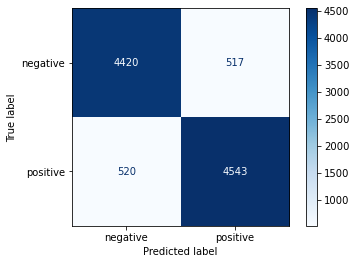

In [50]:
plot_confusion_matrix(best_model_lr, X_val, y_val, cmap = 'Blues', display_labels=['negative', 'positive'])
plt.grid(False)

In [51]:
scores_df.set_index('model')

,accuracy,precision,recall,f1_score,ROC_AUC
model,,,,,
CountVect_LogisticRegression_train,0.997,0.997,0.997,0.997,1.000
CountVect_LogisticRegression_val,0.877,0.881,0.876,0.879,0.945
TfidfVect_LogisticRegression_train,0.934,0.926,0.943,0.934,0.982
TfidfVect_LogisticRegression_val,0.890,0.890,0.894,0.892,0.958
TfidfVect_LogisticRegression_tuned_train,1.000,1.000,1.000,1.000,1.000
TfidfVect_LogisticRegression_tuned_val,0.896,0.898,0.897,0.898,0.956


Almost all our metrics have been slightly improved after tuning the model parameters.

### 1.2. Random Forest

Next model that we are going to deal with is Random Forest. We will reproduce most of the steps from Logistic Regression part, but we will try to simplify and shorten the whole procedure.

We start with the implementation of method which covers all the training routine.

In [52]:
def train_pipeline(
    pipeline: Pipeline, X_train: pd.DataFrame, y_train: pd.Series, X_val: pd.DataFrame, y_val: pd.Series
) -> [Pipeline, dict, dict]:
    """ Trains and evaluates pipeline, calculates and prints all the necessary metrics. """    
    train_metrics, val_metrics = dict(), dict()
    transformer_name = type(pipeline['transformer']).__name__
    model_name = type(pipeline['model']).__name__
    pipeline.fit(X_train, y_train)
    
    y_pred_train = pipeline.predict(X_train)
    # LinearSVC doesn't have predict_proba() method 
    if model_name == 'LinearSVC':
        proba_train = np.empty(0)
    else:
        proba_train = pipeline.predict_proba(X_train)
    print(f'{model_name} metrics on training data:')
    train_metrics['model'] = transformer_name + '_' + model_name + '_train'
    train_metrics.update(calc_metrics(y_train, y_pred_train, proba_train))

    y_pred_val = pipeline.predict(X_val)
    # LinearSVC doesn't have predict_proba() method 
    if model_name == 'LinearSVC':
        proba_val = np.empty(0)
    else:
        proba_val = pipeline.predict_proba(X_val)
    print(f'\n{model_name} metrics on validation data:')
    val_metrics['model'] = transformer_name + '_' + model_name + '_val'
    val_metrics.update(calc_metrics(y_val, y_pred_val, proba_val))

    print(f'\nClassification report and confusion matrix for the validation data:')
    report = classification_report(y_val, y_pred_val, target_names=['negative', 'positive'])
    print(report)
    
    plot_confusion_matrix(pipeline, X_val, y_val, cmap = 'Blues', display_labels=['negative', 'positive'])
    plt.grid(False)
    
    return [pipeline, train_metrics, val_metrics]

In [53]:
pipeline_cv_rf = Pipeline([
    ('transformer', CountVectorizer()),
    ('model', RandomForestClassifier(random_state=SEED)),
])

RandomForestClassifier metrics on training data:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0
ROC-AUC: 1.0

RandomForestClassifier metrics on validation data:
Accuracy: 0.855
Precision: 0.862
Recall: 0.851
F1-score: 0.856
ROC-AUC: 0.931

Classification report and confusion matrix for the validation data:
              precision    recall  f1-score   support

    negative       0.85      0.86      0.85      4937
    positive       0.86      0.85      0.86      5063

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



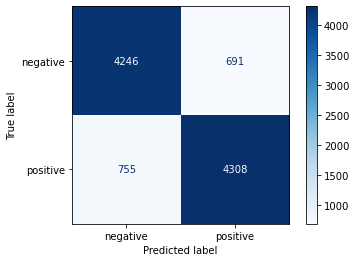

In [54]:
pipeline_cv_rf, train_score, val_score = train_pipeline(pipeline_cv_rf, X_train, y_train, X_val, y_val)

In [55]:
scores_df = scores_df.append([train_score, val_score], ignore_index=True)

In [56]:
pipeline_tfidf_rf = Pipeline([
    ('transformer', TfidfVectorizer()),
    ('model', RandomForestClassifier(random_state=SEED)),
])

RandomForestClassifier metrics on training data:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0
ROC-AUC: 1.0

RandomForestClassifier metrics on validation data:
Accuracy: 0.855
Precision: 0.865
Recall: 0.845
F1-score: 0.855
ROC-AUC: 0.93

Classification report and confusion matrix for the validation data:
              precision    recall  f1-score   support

    negative       0.84      0.86      0.85      4937
    positive       0.86      0.84      0.85      5063

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



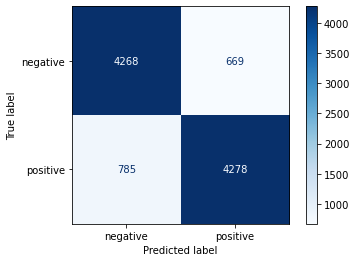

In [57]:
pipeline_tfidf_rf, train_score, val_score = train_pipeline(pipeline_tfidf_rf, X_train, y_train, X_val, y_val)

In [58]:
scores_df = scores_df.append([train_score, val_score], ignore_index=True)

In [59]:
scores_df.set_index('model')

,accuracy,precision,recall,f1_score,ROC_AUC
model,,,,,
CountVect_LogisticRegression_train,0.997,0.997,0.997,0.997,1.000
CountVect_LogisticRegression_val,0.877,0.881,0.876,0.879,0.945
TfidfVect_LogisticRegression_train,0.934,0.926,0.943,0.934,0.982
TfidfVect_LogisticRegression_val,0.890,0.890,0.894,0.892,0.958
TfidfVect_LogisticRegression_tuned_train,1.000,1.000,1.000,1.000,1.000
TfidfVect_LogisticRegression_tuned_val,0.896,0.898,0.897,0.898,0.956
CountVectorizer_RandomForestClassifier_train,1.000,1.000,1.000,1.000,1.000
CountVectorizer_RandomForestClassifier_val,0.855,0.862,0.851,0.856,0.931
TfidfVectorizer_RandomForestClassifier_train,1.000,1.000,1.000,1.000,1.000


The results we got 'out of the box' for the validation part are worse than for Logistic regression. But at the same time all metrics on the training dataset look perfect. Our model overfitted, because we didn't make any changes with it's params (like `max_depth`, `n_estimators` etc.). We can set up these params manually or we can use RandomizedSearchCV method like in previous case.

Also I would like to mention that results we had with RandomForest model after CountVectorizer and TfidfVectorizer are almost the same. And I consider there is no need to tune both pipelines. It will be enough to take one of them, e.g. pipeline with TfidfVectorizer, and tune it using the full train dataset.

In [60]:
pipeline_rf = Pipeline([
    ('transformer', TfidfVectorizer()),
    ('model', RandomForestClassifier(random_state=SEED)),
])

In [61]:
parameters = {
    'transformer__max_df': (0.75, 1),
    'transformer__max_features': (50000, None),
    'transformer__ngram_range': [(1, 2)],
    'model__n_estimators': (10, 50, 100, 200, 500),
    'model__max_depth': (5, 10, 20, 50),
}

In [62]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED)
random_search = RandomizedSearchCV(pipeline_rf, parameters, n_jobs=8, n_iter=50, verbose=True, cv=skf)

In [63]:
%%time
random_search.fit(X_full_train, y_full_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Wall time: 42min 44s


RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('transformer', TfidfVectorizer()),
                                             ('model',
                                              RandomForestClassifier(random_state=42))]),
                   n_iter=50, n_jobs=8,
                   param_distributions={'model__max_depth': (5, 10, 20, 50),
                                        'model__n_estimators': (10, 50, 100,
                                                                200, 500),
                                        'transformer__max_df': (0.75, 1),
                                        'transformer__max_features': (50000,
                                                                      None),
                                        'transformer__ngram_range': [(1, 2)]},
                   verbose=True)

In [64]:
print(f'Best accuracy score: {random_search.best_score_:0.3f}')
print('Best parameters set:')
best_model_rf = random_search.best_estimator_
best_parameters = best_model_rf.get_params()
for param_name in sorted(parameters.keys()):
    print(f'\t{param_name}: {best_parameters[param_name]}')

Best accuracy score: 0.865
Best parameters set:
	model__max_depth: 50
	model__n_estimators: 500
	transformer__max_df: 0.75
	transformer__max_features: None
	transformer__ngram_range: (1, 2)


RandomForestClassifier metrics on training data:
Accuracy: 0.985
Precision: 0.976
Recall: 0.994
F1-score: 0.985
ROC-AUC: 0.999

RandomForestClassifier metrics on validation data:
Accuracy: 0.872
Precision: 0.878
Recall: 0.867
F1-score: 0.873
ROC-AUC: 0.944

Classification report and confusion matrix for the validation data:
              precision    recall  f1-score   support

    negative       0.87      0.88      0.87      4937
    positive       0.88      0.87      0.87      5063

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



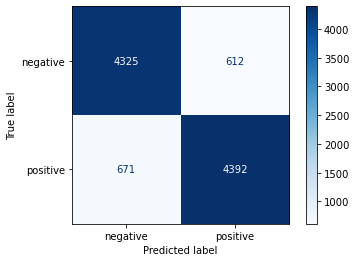

In [65]:
best_model_rf, train_score, val_score = train_pipeline(best_model_rf, X_train, y_train, X_val, y_val)

In [66]:
train_score['model'] = 'TfidfVectorizer_RandomForestClassifier_tuned_train'
val_score['model'] = 'TfidfVectorizer_RandomForestClassifier_tuned_val'
scores_df = scores_df.append([train_score, val_score], ignore_index=True)

In [67]:
scores_df.set_index('model')

,accuracy,precision,recall,f1_score,ROC_AUC
model,,,,,
CountVect_LogisticRegression_train,0.997,0.997,0.997,0.997,1.000
CountVect_LogisticRegression_val,0.877,0.881,0.876,0.879,0.945
TfidfVect_LogisticRegression_train,0.934,0.926,0.943,0.934,0.982
TfidfVect_LogisticRegression_val,0.890,0.890,0.894,0.892,0.958
TfidfVect_LogisticRegression_tuned_train,1.000,1.000,1.000,1.000,1.000
TfidfVect_LogisticRegression_tuned_val,0.896,0.898,0.897,0.898,0.956
CountVectorizer_RandomForestClassifier_train,1.000,1.000,1.000,1.000,1.000
CountVectorizer_RandomForestClassifier_val,0.855,0.862,0.851,0.856,0.931
TfidfVectorizer_RandomForestClassifier_train,1.000,1.000,1.000,1.000,1.000


You can see that after parameters tuning, all the metrics have been boosted up, but they still behind the results we achieved with Logistic Regression.

### 1.3. Linear Support Vector Classification

And the last model we are going to try is Linear Support Vector Classification.

In [68]:
pipeline_cv_svc = Pipeline([
    ('transformer', CountVectorizer()),
    ('model', LinearSVC(random_state=SEED)),
])

LinearSVC metrics on training data:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0
ROC-AUC: None

LinearSVC metrics on validation data:
Accuracy: 0.861
Precision: 0.867
Recall: 0.858
F1-score: 0.862
ROC-AUC: None

Classification report and confusion matrix for the validation data:
              precision    recall  f1-score   support

    negative       0.86      0.86      0.86      4937
    positive       0.87      0.86      0.86      5063

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



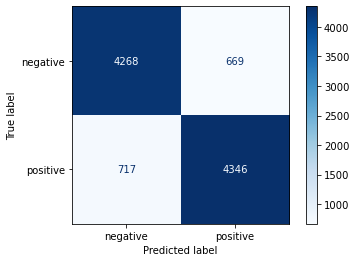

In [69]:
pipeline_cv_svc, train_score, val_score = train_pipeline(pipeline_cv_svc, X_train, y_train, X_val, y_val)

In [70]:
scores_df = scores_df.append([train_score, val_score], ignore_index=True)

In [71]:
pipeline_tfidf_svc = Pipeline([
    ('transformer', TfidfVectorizer()),
    ('model', LinearSVC(random_state=SEED)),
])

LinearSVC metrics on training data:
Accuracy: 0.991
Precision: 0.991
Recall: 0.991
F1-score: 0.991
ROC-AUC: None

LinearSVC metrics on validation data:
Accuracy: 0.889
Precision: 0.892
Recall: 0.888
F1-score: 0.89
ROC-AUC: None

Classification report and confusion matrix for the validation data:
              precision    recall  f1-score   support

    negative       0.89      0.89      0.89      4937
    positive       0.89      0.89      0.89      5063

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



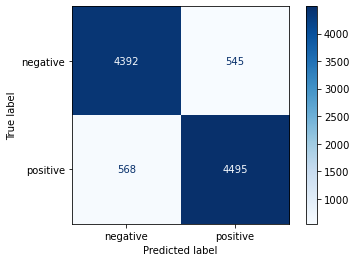

In [72]:
pipeline_tfidf_svc, train_score, val_score = train_pipeline(pipeline_tfidf_svc, X_train, y_train, X_val, y_val)

In [73]:
scores_df = scores_df.append([train_score, val_score], ignore_index=True)

In [74]:
scores_df.set_index('model').tail(4)

,accuracy,precision,recall,f1_score,ROC_AUC
model,,,,,
CountVectorizer_LinearSVC_train,1.000,1.000,1.000,1.000,None
CountVectorizer_LinearSVC_val,0.861,0.867,0.858,0.862,None
TfidfVectorizer_LinearSVC_train,0.991,0.991,0.991,0.991,None
TfidfVectorizer_LinearSVC_val,0.889,0.892,0.888,0.890,None


Pipeline(TfidfVectorizer, LinearSVC) 'out of the box' give us rather good results. It is reasonable to continue parameters tuning of this particular pipeline. So, let's do it.

In [75]:
pipeline_svc = Pipeline([
    ('transformer', TfidfVectorizer()),
    ('model', LinearSVC(random_state=SEED)),
])

In [76]:
parameters = {
    'transformer__max_df': (0.5, 0.75, 1.0),
    'transformer__max_features': (None, 50000),
    'transformer__ngram_range': ((1, 1), (1, 2), (1, 3)),
    'model__C': (0.1, 1, 10),
}

In [77]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED)
random_search = RandomizedSearchCV(pipeline_svc, parameters, n_jobs=8, n_iter=50, verbose=True, cv=skf)

In [78]:
%%time
random_search.fit(X_full_train, y_full_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Wall time: 24min 4s


RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('transformer', TfidfVectorizer()),
                                             ('model',
                                              LinearSVC(random_state=42))]),
                   n_iter=50, n_jobs=8,
                   param_distributions={'model__C': (0.1, 1, 10),
                                        'transformer__max_df': (0.5, 0.75, 1.0),
                                        'transformer__max_features': (None,
                                                                      50000),
                                        'transformer__ngram_range': ((1, 1),
                                                                     (1, 2),
                                                                     (1, 3))},
                   verbose=True)

In [79]:
print(f'Best accuracy score: {random_search.best_score_:0.3f}')
print('Best parameters set:')
best_model_svc = random_search.best_estimator_
best_parameters = best_model_svc.get_params()
for param_name in sorted(parameters.keys()):
    print(f'\t{param_name}: {best_parameters[param_name]}')

Best accuracy score: 0.903
Best parameters set:
	model__C: 10
	transformer__max_df: 0.5
	transformer__max_features: None
	transformer__ngram_range: (1, 2)


Now we take the model with the best params to train it and calculate remaining metrics.

LinearSVC metrics on training data:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0
ROC-AUC: None

LinearSVC metrics on validation data:
Accuracy: 0.903
Precision: 0.902
Recall: 0.908
F1-score: 0.905
ROC-AUC: None

Classification report and confusion matrix for the validation data:
              precision    recall  f1-score   support

    negative       0.91      0.90      0.90      4937
    positive       0.90      0.91      0.90      5063

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



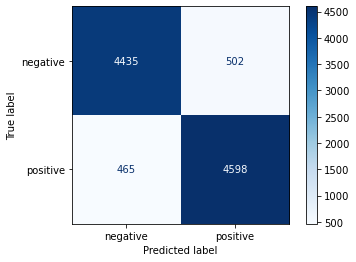

In [80]:
best_model_svc, train_score, val_score = train_pipeline(best_model_svc, X_train, y_train, X_val, y_val)

In [81]:
train_score['model'] = 'TfidfVectorizer_LinearSVC_tuned_train'
val_score['model'] = 'TfidfVectorizer_LinearSVC_tuned_val'
scores_df = scores_df.append([train_score, val_score], ignore_index=True)

And here is what we got.

In [82]:
scores_df.set_index('model')

,accuracy,precision,recall,f1_score,ROC_AUC
model,,,,,
CountVect_LogisticRegression_train,0.997,0.997,0.997,0.997,1.0
CountVect_LogisticRegression_val,0.877,0.881,0.876,0.879,0.945
TfidfVect_LogisticRegression_train,0.934,0.926,0.943,0.934,0.982
TfidfVect_LogisticRegression_val,0.890,0.890,0.894,0.892,0.958
TfidfVect_LogisticRegression_tuned_train,1.000,1.000,1.000,1.000,1.0
TfidfVect_LogisticRegression_tuned_val,0.896,0.898,0.897,0.898,0.956
CountVectorizer_RandomForestClassifier_train,1.000,1.000,1.000,1.000,1.0
CountVectorizer_RandomForestClassifier_val,0.855,0.862,0.851,0.856,0.931
TfidfVectorizer_RandomForestClassifier_train,1.000,1.000,1.000,1.000,1.0


Let's look only at the results of the tuned models.

In [83]:
scores_df[scores_df['model'].str.contains('tuned')].set_index('model')

,accuracy,precision,recall,f1_score,ROC_AUC
model,,,,,
TfidfVect_LogisticRegression_tuned_train,1.000,1.000,1.000,1.000,1.0
TfidfVect_LogisticRegression_tuned_val,0.896,0.898,0.897,0.898,0.956
TfidfVectorizer_RandomForestClassifier_tuned_train,0.985,0.976,0.994,0.985,0.999
TfidfVectorizer_RandomForestClassifier_tuned_val,0.872,0.878,0.867,0.873,0.944
TfidfVectorizer_LinearSVC_tuned_train,1.000,1.000,1.000,1.000,None
TfidfVectorizer_LinearSVC_tuned_val,0.903,0.902,0.908,0.905,None


We got the best results on validation with pipelines (fidfVectorizer, LogisticRegression) and (fidfVectorizer, LinearSVC). Their metrics are pretty close to each other. So, for the next step, you can use any of them. In our case, we are going to select pipeline based on LogisticRegression.

In [84]:
final_model = best_model_lr

## 2. Model testing

Now we need to train the selected model on the full training dataset and validate it on the hold-out test part.

In [85]:
test_df = pd.read_csv(DATA_DIR + '/processed/test.csv', index_col=0)

In [86]:
print(test_df.shape)
test_df.head(5)

(10000, 2)


,review,sentiment
0,really liked summerslam due look arena curtain...,1
1,many television show appeal quite many differe...,1
2,film quickly get major chase scene ever increa...,0
3,jane austen would definitely approve onegwynet...,1
4,expectation somewhat high went see movie thoug...,0


In [87]:
full_train_df = full_train_df.drop_duplicates()

In [88]:
X_full_train, y_full_train = full_train_df['review'], full_train_df['sentiment']
X_test, y_test = test_df['review'], test_df['sentiment']

In [89]:
print(f'Full training dataset shape is {X_full_train.shape}, test part shape is {X_test.shape}.')

Full training dataset shape is (39740,), test part shape is (10000,).


LogisticRegression metrics on training data:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0
ROC-AUC: 1.0

LogisticRegression metrics on validation data:
Accuracy: 0.907
Precision: 0.897
Recall: 0.921
F1-score: 0.909
ROC-AUC: 0.968

Classification report and confusion matrix for the validation data:
              precision    recall  f1-score   support

    negative       0.92      0.89      0.91      4961
    positive       0.90      0.92      0.91      5039

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



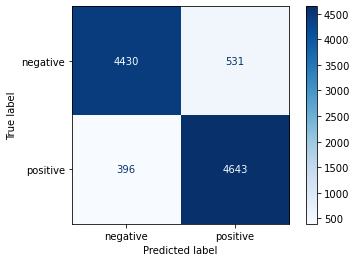

In [90]:
final_model, full_train_score, test_score = train_pipeline(final_model, X_full_train, y_full_train, X_test, y_test)

In [91]:
with open(MODEL_DIR + '/model.pkl', 'wb') as f_out: 
    pickle.dump(final_model, f_out)

**Conclusion:**
- We tried 2 types of text transformations based on BoW and TF-IDF features and 3 different variants of classifiers - Logistic Regression, Random Forest Classifier and Linear Support Vector Classification.
- Also we carried out the parameters tuning with RandomizedSearchCV and slightly boosted up our models metrics.
- We got the best metrics with the following pipelines: (fidfVectorizer, LogisticRegression) and (fidfVectorizer, LinearSVC). Pipeline(fidfVectorizer, LogisticRegression) have been chosen as the final one.